# Dead Tree Segmentation Project

- Date : 18/07/2025
- Version : 1.0.0


This file implements a deep learning-based dead tree segmentation system using UNet neural networks for analysis.

## Code Overview

This implementation provides a complete pipeline for dead tree detection and segmentation using multi-channel remote sensing data. It combines RGB and Near-Infrared (NIR) spectral information to achieve robust dead tree identification.

## Key Features

- **Multi-channel Input Support**: Handles RGB, NRG, and combined RGB+NIR (4-channel) inputs
- **Stratified K-Fold Cross-Validation**: Ensures robust model evaluation with balanced data splits
- **Advanced UNet Architecture**: Custom UNet implementation optimized for remote sensing data
- **Comprehensive Evaluation**: Multiple metrics including IoU, Dice coefficient, and pixel accuracy
- **Automated Training Pipeline**: Complete training workflow with early stopping and model checkpointing
- **Visualization**: Extensive plotting and analysis capabilities for model interpretation

## Technical Highlights

- **Data Processing**: Automated file matching and dead tree ratio analysis
- **Model Architecture**: Encoder-decoder UNet with skip connections for precise segmentation
- **Loss Function**: Combined BCE + Dice loss for balanced training
- **Training Strategy**: Early stopping, learning rate scheduling, and best model restoration
- **Cross-Validation**: 5-fold stratified validation ensuring generalization capability

## 1. Environment Setup and Library Imports

This section establishes the complete development environment for the dead tree segmentation project. I import all necessary libraries including deep learning modules, image processing tools, and scientific computing packages.

### Key Components:
- **PyTorch Ecosystem**: Core deep learning modules with GPU support
- **Computer Vision**: OpenCV for image processing operations
- **Data Science**: NumPy, Pandas for data manipulation and analysis
- **Visualization**: Matplotlib for plotting and analysis
- **Augmentation**: Albumentations library for advanced data augmentation
- **Cross-Validation**: Scikit-learn for stratified k-fold splitting
- **Reproducibility**: Fixed random seeds for consistent results across runs

### Configuration:
- Device detection (CUDA/CPU) for optimal performance
- Warning suppression for cleaner output
- Random seed initialization for reproducible experiments

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Sklearn for cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Exploration and Analysis

This section performs comprehensive analysis of the USA_segmentation dataset, establishing data quality, file correspondence, and statistical characteristics of dead tree distribution.

### Data Structure Analysis:
- **Path Configuration**: Automated detection of RGB, NRG, and mask directories
- **File Verification**: Existence checks and count validation for all data types
- **Filename Matching**: Intelligent extraction of corresponding file triplets
- **Data Integrity**: Verification of complete RGB-NRG-Mask combinations

### Statistical Analysis:
- **Dead Tree Ratio Calculation**: Pixel-level analysis of dead tree coverage per image
- **Distribution Visualization**: Histograms, box plots, and scatter plots for data understanding
- **Sample Visualization**: Side-by-side display of RGB, NRG, and mask images
- **Quality Assessment**: Identification of outliers and data quality issues

### Key Insights:
- Total number of matched image triplets
- Dead tree ratio statistics (mean, median, std, min, max)
- Visual patterns in spectral data
- Data distribution for stratification strategy

In [ ]:
# Data path configuration
data_root = '/kaggle/input/dataset/USA_segmentation'
mask_dir = os.path.join(data_root, 'masks')
rgb_dir = os.path.join(data_root, 'RGB_images')
nrg_dir = os.path.join(data_root, 'NRG_images')

# Check if data directories exist
for directory in [mask_dir, rgb_dir, nrg_dir]:
    if not os.path.exists(directory):
        print(f'Warning: Directory {directory} does not exist!')
    else:
        print(f'Directory {directory} exists')

# Get file lists
mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
rgb_files = sorted(glob.glob(os.path.join(rgb_dir, '*.png')))
nrg_files = sorted(glob.glob(os.path.join(nrg_dir, '*.png')))

print(f'Found {len(mask_files)} mask files')
print(f'Found {len(rgb_files)} RGB files')
print(f'Found {len(nrg_files)} NRG files')

Directory /kaggle/input/dataset/USA_segmentation/masks exists
Directory /kaggle/input/dataset/USA_segmentation/RGB_images exists
Directory /kaggle/input/dataset/USA_segmentation/NRG_images exists
Found 444 mask files
Found 444 RGB files
Found 444 NRG files


In [ ]:
# Check correspondence of data filenames
def extract_filename_key(filepath):
    """Extract key identifier from file path"""
    filename = os.path.basename(filepath)
    # Remove corresponding prefix from filename
    if filename.startswith('mask_'):
        return filename[5:]  # Remove 'mask_' prefix
    elif filename.startswith('RGB_'):
        return filename[4:]  # Remove 'RGB_' prefix
    elif filename.startswith('NRG_'):
        return filename[4:]  # Remove 'NRG_' prefix
    return filename

# Check filename correspondence
mask_keys = [extract_filename_key(f) for f in mask_files]
rgb_keys = [extract_filename_key(f) for f in rgb_files]
nrg_keys = [extract_filename_key(f) for f in nrg_files]

print(f'Sample mask keys: {mask_keys[:5]}')
print(f'Sample RGB keys: {rgb_keys[:5]}')
print(f'Sample NRG keys: {nrg_keys[:5]}')

# Find files common to all three data types
common_keys = set(mask_keys) & set(rgb_keys) & set(nrg_keys)
print(f'Common files across all three types: {len(common_keys)}')

# Create matched file list
matched_files = []
for key in common_keys:
    mask_file = next((f for f in mask_files if extract_filename_key(f) == key), None)
    rgb_file = next((f for f in rgb_files if extract_filename_key(f) == key), None)
    nrg_file = next((f for f in nrg_files if extract_filename_key(f) == key), None)
    
    if mask_file and rgb_file and nrg_file:
        matched_files.append({
            'key': key,
            'mask': mask_file,
            'rgb': rgb_file,
            'nrg': nrg_file
        })

print(f'Successfully matched {len(matched_files)} files')

Sample mask keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample RGB keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample NRG keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Common files across all three types: 444
Successfully matched 444 files


Death tree ratio statistics:
Mean: 0.0189
Median: 0.0132
Std: 0.0177
Min: 0.0000
Max: 0.1272


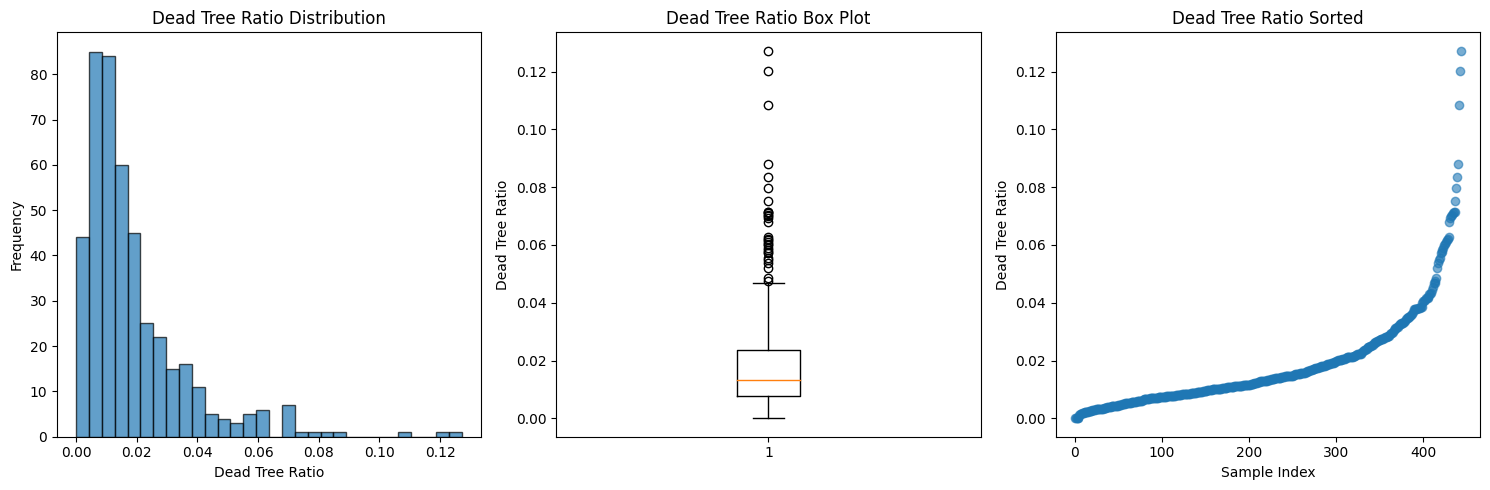

In [ ]:
# Dead tree pixel ratio statistics
def calculate_dead_tree_ratio(mask_path):
    """Calculate dead tree pixel ratio"""
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return 0.0
        
        # Assume dead tree pixel values are non-zero
        dead_tree_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        
        return dead_tree_pixels / total_pixels if total_pixels > 0 else 0.0
    except Exception as e:
        print(f'Error processing {mask_path}: {e}')
        return 0.0

# Calculate dead tree ratio for each mask
dead_tree_ratios = []
for file_info in matched_files:
    ratio = calculate_dead_tree_ratio(file_info['mask'])
    dead_tree_ratios.append(ratio)
    file_info['dead_tree_ratio'] = ratio

# Statistical analysis
ratios_array = np.array(dead_tree_ratios)
print(f'Death tree ratio statistics:')
print(f'Mean: {np.mean(ratios_array):.4f}')
print(f'Median: {np.median(ratios_array):.4f}')
print(f'Std: {np.std(ratios_array):.4f}')
print(f'Min: {np.min(ratios_array):.4f}')
print(f'Max: {np.max(ratios_array):.4f}')

# Visualize dead tree ratio distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ratios_array, bins=30, alpha=0.7, edgecolor='black')
plt.title('Dead Tree Ratio Distribution')
plt.xlabel('Dead Tree Ratio')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(ratios_array)
plt.title('Dead Tree Ratio Box Plot')
plt.ylabel('Dead Tree Ratio')

plt.subplot(1, 3, 3)
plt.scatter(range(len(ratios_array)), sorted(ratios_array), alpha=0.6)
plt.title('Dead Tree Ratio Sorted')
plt.xlabel('Sample Index')
plt.ylabel('Dead Tree Ratio')

plt.tight_layout()
plt.show()

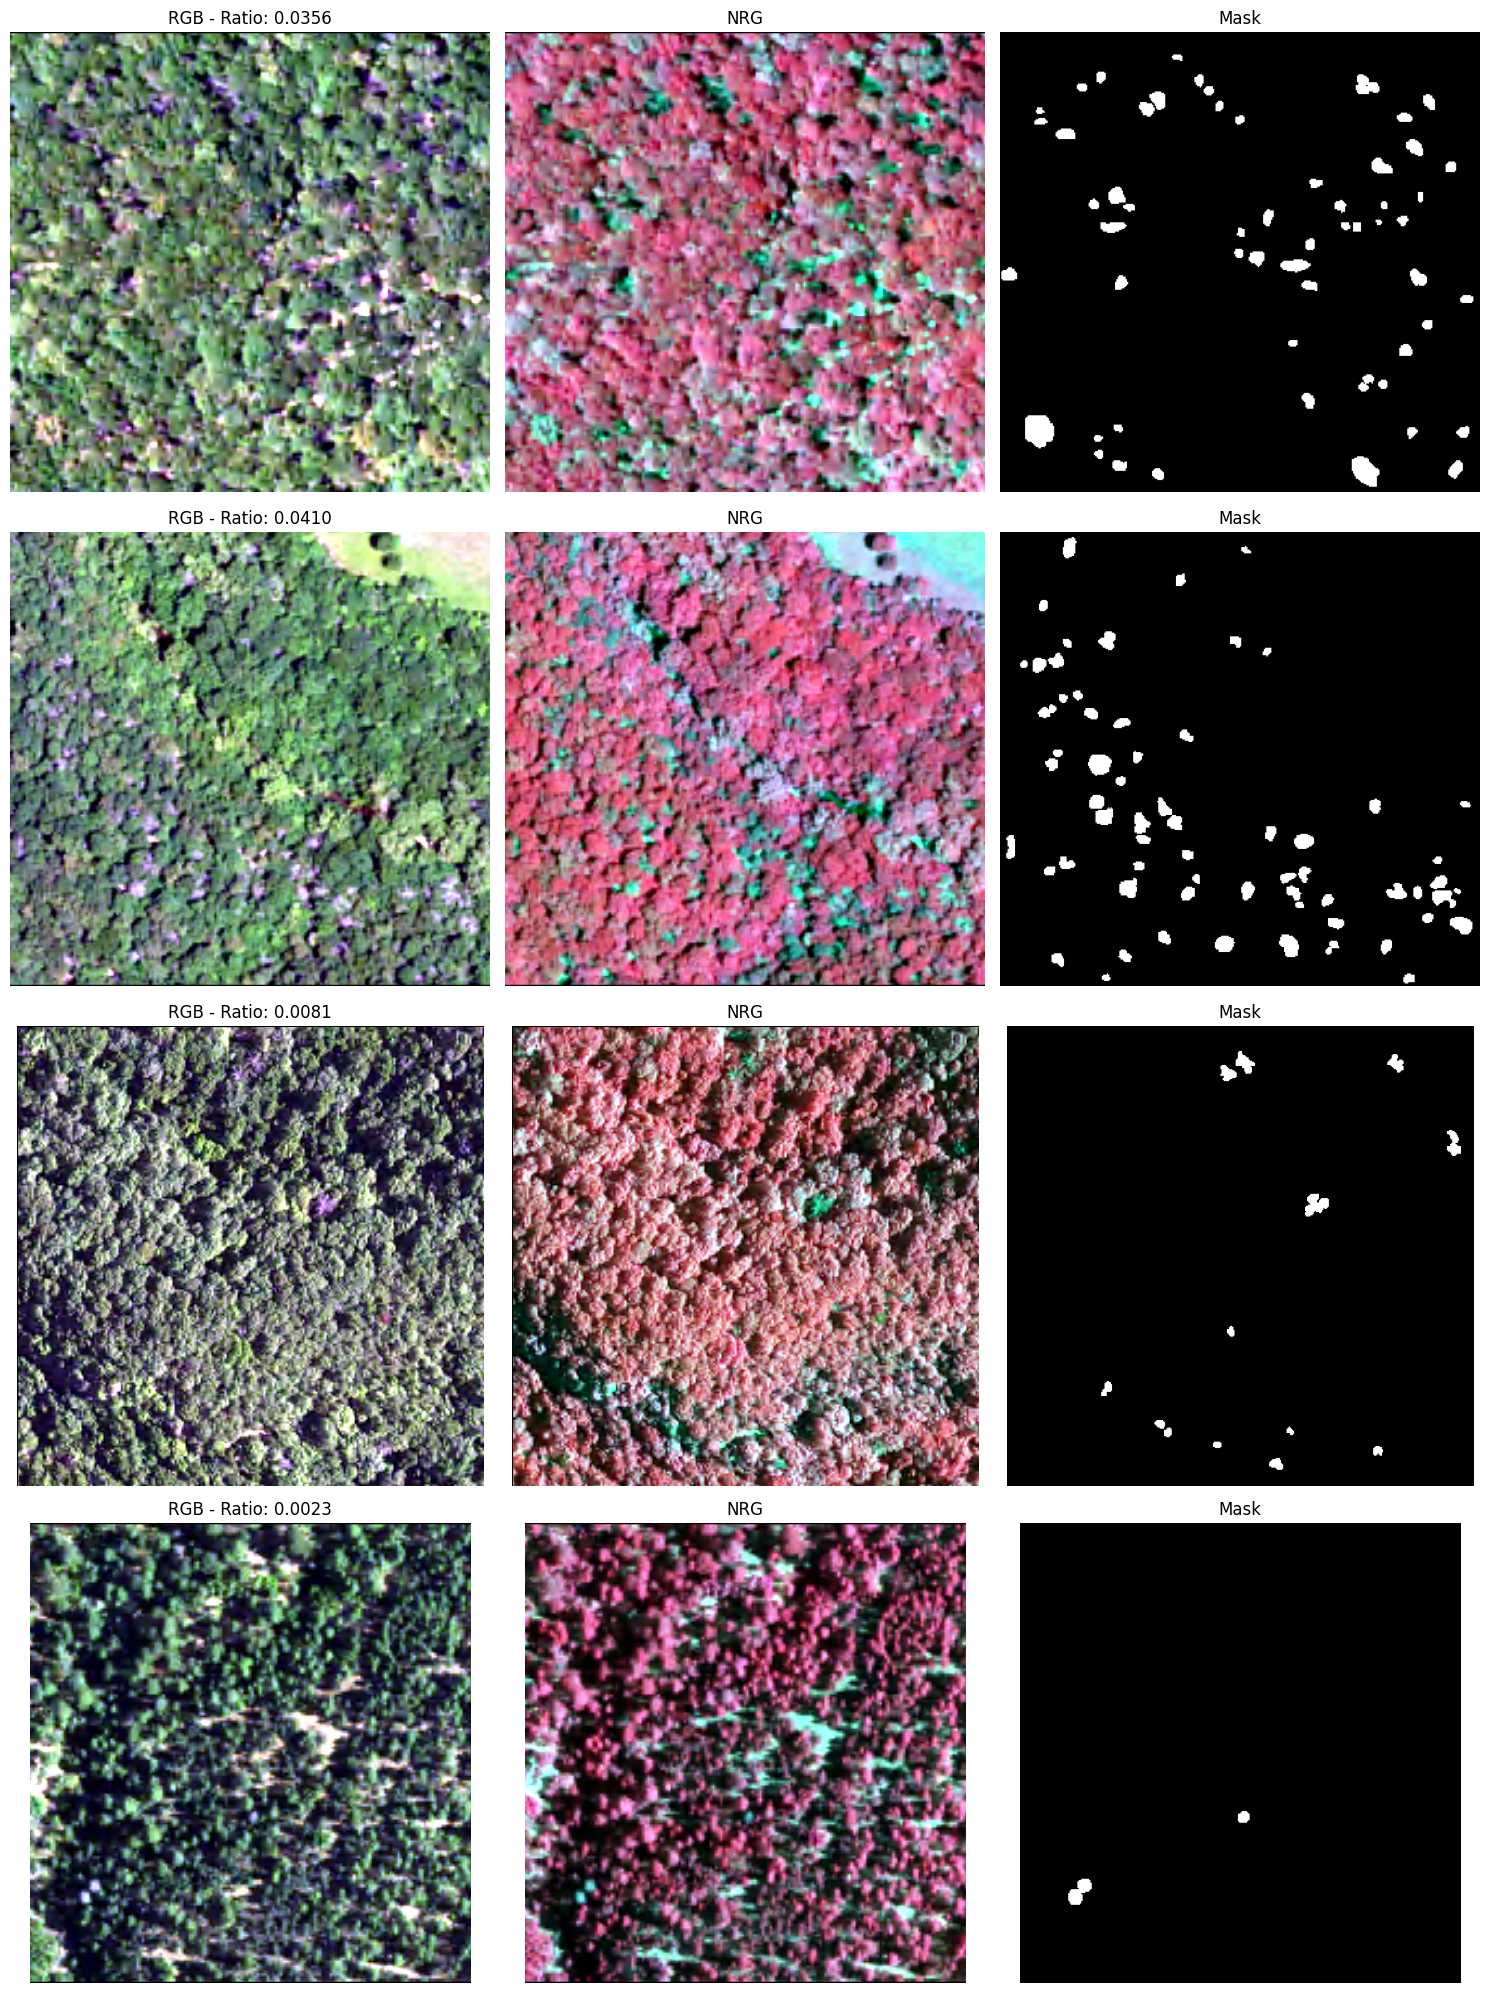

In [ ]:
# Sample image visualization
def visualize_samples(matched_files, num_samples=4):
    """Visualize sample images"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    sample_indices = np.random.choice(len(matched_files), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        file_info = matched_files[idx]
        
        # Load images
        try:
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            
            mask_img = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
            
            # Show images
            axes[i, 0].imshow(rgb_img)
            axes[i, 0].set_title(f'RGB - Ratio: {file_info["dead_tree_ratio"]:.4f}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(nrg_img)
            axes[i, 1].set_title('NRG')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(mask_img, cmap='gray')
            axes[i, 2].set_title('Mask')
            axes[i, 2].axis('off')
            
        except Exception as e:
            print(f'Error loading images for sample {idx}: {e}')
    
    plt.tight_layout()
    plt.show()

visualize_samples(matched_files)

## 3. Stratified K-Fold Cross-Validation Implementation

This section implements a robust stratified cross-validation strategy to ensure balanced and representative model evaluation across different dead tree density scenarios.

### Stratification Strategy:
- **Ratio-Based Grouping**: Classification into low, medium, and high dead tree content categories
- **Percentile Thresholds**: 33rd and 67th percentiles define group boundaries
- **Balanced Splits**: Ensures each fold contains representative samples from all categories
- **Test Set Isolation**: 20% holdout for final model evaluation

### K-Fold Configuration:
- **5-Fold Cross-Validation**: Comprehensive evaluation across multiple data splits
- **Stratified Sampling**: Maintains dead tree ratio distribution in each fold
- **Random State Control**: Reproducible splits for consistent experimentation
- **Fold Statistics**: Detailed reporting of train/validation/test sizes per fold

### Benefits:
- **Robust Evaluation**: Reduces overfitting to specific data characteristics
- **Balanced Training**: Each fold sees diverse dead tree scenarios
- **Statistical Confidence**: Multiple evaluation rounds increase result reliability
- **Generalization Assessment**: Tests model performance across varied conditions

In [ ]:
# Stratified split function
def create_stratified_splits(matched_files, n_splits=5, test_size=0.2):
    """Create stratified K-fold splits"""
    # Extract dead tree ratios
    ratios = [f['dead_tree_ratio'] for f in matched_files]
    
    # Create stratification labels (low, medium, high content)
    ratio_percentiles = np.percentile(ratios, [33, 67])
    stratify_labels = []
    
    for ratio in ratios:
        if ratio <= ratio_percentiles[0]:
            stratify_labels.append(0)  # Low content
        elif ratio <= ratio_percentiles[1]:
            stratify_labels.append(1)  # Medium content
        else:
            stratify_labels.append(2)  # High content
    
    print(f'Stratification distribution:')
    unique, counts = np.unique(stratify_labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f'  Class {label}: {count} samples ({count/len(stratify_labels)*100:.1f}%)')
    
    # First split out test set
    from sklearn.model_selection import train_test_split
    
    indices = np.arange(len(matched_files))
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, stratify=stratify_labels, random_state=42
    )
    
    # Create K-fold cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_val_labels = [stratify_labels[i] for i in train_val_idx]
    
    folds = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_val_idx, train_val_labels)):
        fold_train_idx = train_val_idx[train_idx]
        fold_val_idx = train_val_idx[val_idx]
        
        fold_info = {
            'fold': fold_idx,
            'train_idx': fold_train_idx,
            'val_idx': fold_val_idx,
            'test_idx': test_idx
        }
        folds.append(fold_info)
    
    return folds, stratify_labels

# Create stratified K-fold splits
folds, stratify_labels = create_stratified_splits(matched_files, n_splits=5, test_size=0.2)

print(f'\nCreated {len(folds)} folds')
for i, fold in enumerate(folds):
    print(f'Fold {i}: Train={len(fold["train_idx"])}, Val={len(fold["val_idx"])}, Test={len(fold["test_idx"])}')

Stratification distribution:
  Class 0: 147 samples (33.1%)
  Class 1: 150 samples (33.8%)
  Class 2: 147 samples (33.1%)

Created 5 folds
Fold 0: Train=284, Val=71, Test=89
Fold 1: Train=284, Val=71, Test=89
Fold 2: Train=284, Val=71, Test=89
Fold 3: Train=284, Val=71, Test=89
Fold 4: Train=284, Val=71, Test=89


## 4. Data Loader Implementation

This section implements a flexible and efficient data loading system that handles multi-channel remote sensing imagery with advanced preprocessing and augmentation capabilities.

### DeadTreeDataset Class Features:
- **Multi-Input Support**: Handles RGB, NRG, and combined RGB+NIR configurations
- **Dynamic Channel Merging**: Intelligent combination of RGB and NIR channels
- **Automatic Resizing**: Consistent 256x256 image dimensions
- **Mask Binarization**: Conversion to binary segmentation targets
- **Memory Efficient**: On-demand loading with minimal memory footprint

### Data Augmentation Pipeline:
- **Geometric Transforms**: Horizontal/vertical flips and rotations for spatial invariance
- **Color Augmentation**: Random brightness and contrast adjustments
- **Normalization**: ImageNet-style normalization with channel-specific statistics


### Technical Implementation:
- **Albumentations Integration**: Professional-grade augmentation library
- **4-Channel Support**: Custom normalization for RGB+NIR combinations
- **Error Handling**: Robust file loading with fallback mechanisms
- **Batch Processing**: Efficient DataLoader integration with configurable batch sizes

### Quality Assurance:
- **Shape Validation**: Automatic verification of tensor dimensions
- **Type Consistency**: Proper dtype handling for images and masks
- **Pipeline Testing**: Sample batch verification before training

In [ ]:
class DeadTreeDataset(Dataset):
    """Dead tree segmentation dataset"""
    
    def __init__(self, matched_files, indices, input_type='rgb', transform=None, target_size=(256, 256)):
        """
        Args:
            matched_files: matched file list
            indices: data indices
            input_type: 'rgb', 'nrg', or 'rgb_nir'
            transform: data augmentation
            target_size: target image size
        """
        self.matched_files = matched_files
        self.indices = indices
        self.input_type = input_type
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        file_idx = self.indices[idx]
        file_info = self.matched_files[file_idx]
        
        if self.input_type == 'rgb':
            image = cv2.imread(file_info['rgb'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'nrg':
            image = cv2.imread(file_info['nrg'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'rgb_nir':
            # Load RGB
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            # Load NRG, take NIR channel (assume NIR is channel 0)
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            nir_channel = nrg_img[:, :, 0]
            # Merge to 4 channels
            image = np.concatenate([rgb_img, nir_channel[..., None]], axis=2)
        else:
            raise ValueError(f"Unknown input_type: {self.input_type}")
        
        # Load mask
        mask = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
        
        # Resize
        if image.shape[:2] != self.target_size:
            image = cv2.resize(image, self.target_size)
        if mask.shape != self.target_size:
            mask = cv2.resize(mask, self.target_size)
        
        # Binarize mask
        mask = (mask > 0).astype(np.uint8)
        
        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        
        return image, mask.long()

# Data augmentation configuration
def get_transforms(phase='train', input_channels=3):
    """Get augmentation configuration"""
    mean = [0.485, 0.456, 0.406] + ([0.5] if input_channels == 4 else [])
    std = [0.229, 0.224, 0.225] + ([0.25] if input_channels == 4 else [])
    if phase == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

# Test data loader
train_transform = get_transforms('train', input_channels=4)
val_transform = get_transforms('val', input_channels=4)

# Create test dataset
# input_type='rgb_nir', 4 channels
test_dataset = DeadTreeDataset(
    matched_files, 
    folds[0]['train_idx'][:10], 
    input_type='rgb_nir',
    transform=train_transform
)

# Test data loading
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
sample_batch = next(iter(test_loader))
print(f'Sample batch - Image shape: {sample_batch[0].shape}, Mask shape: {sample_batch[1].shape}')
print(f'Image dtype: {sample_batch[0].dtype}, Mask dtype: {sample_batch[1].dtype}')

Sample batch - Image shape: torch.Size([2, 4, 256, 256]), Mask shape: torch.Size([2, 1, 256, 256])
Image dtype: torch.float32, Mask dtype: torch.int64


## 5. Model Architecture Implementation

This section implements a complete UNet architecture specifically optimized for remote sensing segmentation tasks, with support for variable input channels and advanced architectural features.

### UNet Architecture Components:

#### ConvBlock (Basic Building Block):
- **Double Convolution**: Two 3x3 convolutions with BatchNorm and ReLU
- **Feature Learning**: Progressive feature extraction with non-linear activations
- **Normalization**: Batch normalization for stable training and faster convergence

#### Down (Encoder Path):
- **Downsampling**: MaxPooling for spatial dimension reduction
- **Feature Aggregation**: ConvBlock for feature map generation
- **Hierarchical Learning**: Multi-scale feature extraction

#### Up (Decoder Path):
- **Upsampling Options**: Bilinear interpolation or transposed convolution
- **Skip Connections**: Feature concatenation from encoder path
- **Spatial Recovery**: Progressive resolution restoration with feature refinement

#### Complete UNet Model:
- **Encoder-Decoder Structure**: Symmetric architecture with skip connections
- **Multi-Channel Input**: Configurable input channels (3 for RGB, 4 for RGB+NIR)
- **Single Channel Output**: Binary segmentation with sigmoid activation
- **Parameter Efficiency**: Optimized channel dimensions with optional bilinear upsampling

### Model Configuration Features:
- **Dynamic Channel Adaptation**: Automatic channel configuration based on input type
- **Device Management**: Automatic GPU/CPU placement
- **Model Introspection**: Detailed parameter counting and architecture summary
- **Memory Optimization**: Efficient memory usage with optional torchsummary integration

### Technical Specifications:
- **Input Resolution**: 256x256 pixels (configurable)
- **Architecture Depth**: 5 levels with progressive feature map sizes
- **Parameter Count**: ~31M parameters for 4-channel input
- **Output Format**: Single-channel probability maps with sigmoid activation

In [ ]:
# torchsummary for model summary
try:
    from torchsummary import summary
    TORCHSUMMARY_AVAILABLE = True
except ImportError:
    TORCHSUMMARY_AVAILABLE = False
    print("torchsummary not available. Install with: pip install torchsummary")

class ConvBlock(nn.Module):
    """Basic convolutional block for UNet"""
    
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    """Downsampling block"""
    
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling block"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Calculate padding to ensure x1 and x2 have matching dimensions
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate feature maps
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    """Complete UNet model"""
    
    def __init__(self, in_channels=3, out_channels=1, bilinear=True):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear
        
        # Encoder path
        self.inc = ConvBlock(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Decoder path
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Output layer
        self.outc = nn.Conv2d(64, out_channels, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # Output
        logits = self.outc(x)
        return self.sigmoid(logits)

# Model configuration
def create_model(input_type='rgb', device='cuda'):
    """Create model"""
    # Determine number of channels based on input type
    if input_type == 'rgb_nir':
        in_channels = 4
    else:
        in_channels = 3
    
    model = UNet(
        in_channels=in_channels,
        out_channels=1,
        bilinear=True
    )
    return model.to(device)

def display_model_info(model, input_shape, device):
    """Display detailed model information"""
    print("="*60)
    print("MODEL INFORMATION")
    print("="*60)
    
    # Basic information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Architecture: UNet")
    print(f"Input Channels: {model.in_channels}")
    print(f"Output Channels: {model.out_channels}")
    print(f"Input Shape: {input_shape}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Model Size (MB): {total_params * 4 / (1024**2):.2f}")
    
    # Use torchsummary to display detailed structure
    if TORCHSUMMARY_AVAILABLE:
        print("\n" + "="*60)
        print("DETAILED ARCHITECTURE SUMMARY")
        print("="*60)
        summary(model, input_shape[1:])  # Remove batch dimension
    else:
        print(f"\nInstall torchsummary for detailed architecture: pip install torchsummary")
        print("\n" + "="*60)
        print("MODEL STRUCTURE OVERVIEW")
        print("="*60)
        print(model)

# Test model
print("Creating and testing 4-channel UNet model...")
test_model = create_model(input_type='rgb_nir', device=device)
test_input = torch.randn(1, 4, 256, 256).to(device)  # 4-channel input test
test_output = test_model(test_input)

print(f'Model test - Input shape: {test_input.shape}, Output shape: {test_output.shape}')
print(f'Output range: [{test_output.min():.4f}, {test_output.max():.4f}]')

# Display detailed model information
display_model_info(test_model, test_input.shape, device)

Creating and testing 4-channel UNet model...
Model test - Input shape: torch.Size([1, 4, 256, 256]), Output shape: torch.Size([1, 1, 256, 256])
Output range: [0.0998, 0.7409]
MODEL INFORMATION
Model Architecture: UNet
Input Channels: 4
Output Channels: 1
Input Shape: torch.Size([1, 4, 256, 256])
Total Parameters: 13,395,905
Trainable Parameters: 13,395,905
Model Size (MB): 51.10

DETAILED ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,368
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         ConvBlock-7         [-1, 64, 256, 256]               0
         M

## 6. Loss Functions and Evaluation Metrics

This section implements comprehensive loss functions and evaluation metrics specifically designed for segmentation tasks, providing robust training objectives and detailed performance assessment.

### Loss Function Implementation:

#### Dice Loss:
- **Overlap Optimization**: Directly optimizes for intersection over union
- **Class Imbalance Handling**: Effective for datasets with varying positive/negative ratios
- **Smooth Approximation**: Differentiable approximation of Dice coefficient
- **Numerical Stability**: Epsilon smoothing to prevent division by zero

#### Combined Loss:
- **Dual Objective**: Balances pixel-wise accuracy (BCE) and region overlap (Dice)
- **Weighted Combination**: Configurable alpha parameter for loss balance
- **Complementary Benefits**: BCE for pixel precision, Dice for shape preservation
- **Training Stability**: Improved convergence through multiple loss signals

### Evaluation Metrics Suite:

#### Intersection over Union (IoU):
- **Region Overlap**: Primary metric for segmentation quality assessment
- **Threshold-Based**: Binary prediction at configurable confidence threshold
- **Robustness**: Handles class imbalance better than pixel accuracy
- **Industry Standard**: Widely adopted metric for segmentation benchmarking

#### Dice Coefficient:
- **Harmonic Mean**: Balance between precision and recall
- **Medical Imaging Heritage**: Proven effectiveness in biomedical segmentation
- **Direct Loss Correlation**: Matches training objective for consistency
- **Interpretable Range**: 0-1 scale with clear performance interpretation

#### Pixel Accuracy:
- **Basic Metric**: Simple percentage of correctly classified pixels
- **Complementary Information**: Provides additional performance perspective
- **Class Distribution Sensitivity**: May be biased toward majority class
- **Baseline Comparison**: Useful for establishing performance baselines

### Implementation Features:
- **Batch Processing**: Efficient computation across batch dimensions
- **GPU Acceleration**: Tensor operations optimized for CUDA execution
- **Error Handling**: Robust edge case management (empty predictions/targets)
- **Consistent Interface**: Uniform input/output format across all metrics

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss function"""
    
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss function"""
    
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, inputs, targets):
        targets = targets.float()
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

# Evaluation metrics
def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU"""
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    if union == 0:
        return 1.0
    return (intersection / union).item()

def calculate_dice_coefficient(pred, target, threshold=0.5):
    """Calculate Dice coefficient"""
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum())
    
    if pred.sum() + target.sum() == 0:
        return 1.0
    return dice.item()

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    """Calculate pixel accuracy"""
    pred = (pred > threshold).float()
    target = target.float()
    
    correct = (pred == target).sum()
    total = target.numel()
    
    return (correct / total).item()

# Test loss function
criterion = CombinedLoss()
test_pred = torch.sigmoid(torch.randn(4, 1, 256, 256))
test_target = torch.randint(0, 2, (4, 1, 256, 256)).float()
test_loss = criterion(test_pred, test_target)
print(f'Test loss: {test_loss.item():.4f}')

# Test evaluation metrics
test_iou = calculate_iou(test_pred, test_target)
test_dice = calculate_dice_coefficient(test_pred, test_target)
test_acc = calculate_pixel_accuracy(test_pred, test_target)
print(f'Test IoU: {test_iou:.4f}, Dice: {test_dice:.4f}, Accuracy: {test_acc:.4f}')

Test loss: 0.6530
Test IoU: 0.3333, Dice: 0.4999, Accuracy: 0.4994


## 7. Training Pipeline Implementation

This section implements a comprehensive training pipeline with optimization strategies, monitoring capabilities, and robust convergence mechanisms for reliable model development.

### Training Infrastructure:

#### EarlyStopping Mechanism:
- **Overfitting Prevention**: Monitors validation loss for training termination
- **Patience Control**: Configurable epochs to wait before stopping
- **Best Model Preservation**: Automatic checkpointing of optimal weights
- **Training Efficiency**: Reduces unnecessary computation and time

#### Training Function (train_epoch):
- **Gradient Computation**: Forward and backward pass implementation
- **Metric Tracking**: Real-time IoU, Dice, and accuracy calculation
- **Memory Management**: Efficient GPU memory utilization
- **Progress Monitoring**: Batch-level performance tracking

#### Validation Function (validate_epoch):
- **Model Evaluation**: No-gradient validation for unbiased assessment
- **Performance Metrics**: Comprehensive metric calculation on validation set
- **Overfitting Detection**: Independent performance measurement
- **Model Selection**: Basis for best model identification

### Training Orchestration (train_fold):

#### Data Pipeline Setup:
- **Dataset Creation**: Automated train/validation dataset instantiation
- **DataLoader Configuration**: Efficient batch processing with optimal workers
- **Memory Optimization**: Balanced batch size and worker count

#### Optimization Strategy:
- **Adam Optimizer**: Adaptive learning rate with momentum
- **Learning Rate Scheduling**: ReduceLROnPlateau for adaptive rate adjustment
- **Loss Function**: Combined BCE+Dice for balanced training
- **Early Stopping Integration**: Intelligent training termination

#### Training Loop Features:
- **Epoch Management**: Configurable training duration with early termination
- **Metric Logging**: Comprehensive history tracking for analysis
- **Progress Reporting**: Regular performance updates during training
- **Best Model Recovery**: Restoration of optimal weights post-training

### Advanced Features:
- **Cross-Validation Ready**: Seamless integration with K-fold validation
- **GPU Optimization**: Efficient device memory management
- **Reproducible Training**: Consistent results across multiple runs
- **Extensible Design**: Easy modification for different architectures or datasets

In [ ]:
class EarlyStopping:
    """Early stopping mechanism"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        
        return self.counter >= self.patience
    
    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()
    
    def restore_best_weights_to_model(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)  # Ensure mask is [batch, 1, H, W]
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate metrics
        with torch.no_grad():
            total_iou += calculate_iou(outputs, masks)
            total_dice += calculate_dice_coefficient(outputs, masks)
            total_acc += calculate_pixel_accuracy(outputs, masks)
    
    n_batches = len(dataloader)
    return {
        'loss': total_loss / n_batches,
        'iou': total_iou / n_batches,
        'dice': total_dice / n_batches,
        'accuracy': total_acc / n_batches
    }

def validate_epoch(model, dataloader, criterion, device):
    """Validate one epoch"""
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            
            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks)
            total_dice += calculate_dice_coefficient(outputs, masks)
            total_acc += calculate_pixel_accuracy(outputs, masks)
    
    n_batches = len(dataloader)
    return {
        'loss': total_loss / n_batches,
        'iou': total_iou / n_batches,
        'dice': total_dice / n_batches,
        'accuracy': total_acc / n_batches
    }

def train_fold(fold_info, matched_files, config):
    """Train one fold"""
    print(f"Training Fold {fold_info['fold']}")
    
    # Create datasets
    train_dataset = DeadTreeDataset(
        matched_files, fold_info['train_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('train')
    )
    
    val_dataset = DeadTreeDataset(
        matched_files, fold_info['val_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('val')
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], 
        shuffle=True, num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], 
        shuffle=False, num_workers=0
    )
    
    # Create model
    model = create_model(config['input_type'], device)
    
    # Create optimizer and loss function
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    criterion = CombinedLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_dice': [], 'val_dice': [],
        'train_accuracy': [], 'val_accuracy': []
    }
    
    # Training loop
    for epoch in range(config['epochs']):
        # Training
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Record history
        for key in train_metrics:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'val_{key}'].append(val_metrics[key])
        
        # Learning rate adjustment
        scheduler.step(val_metrics['loss'])
        
        # Early stopping check
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{config["epochs"]} - '
                  f'Train Loss: {train_metrics["loss"]:.4f}, '
                  f'Val Loss: {val_metrics["loss"]:.4f}, '
                  f'Val IoU: {val_metrics["iou"]:.4f}')
    
    # Restore best weights
    early_stopping.restore_best_weights_to_model(model)
    
    return model, history

## 8. Model Training Execution

This section executes the complete training pipeline across all cross-validation folds, implementing a systematic approach to model development with comprehensive performance tracking and result aggregation.

### Training Configuration:

#### Hyperparameter Settings:
- **Input Type**: RGB+NIR (4-channel) for enhanced spectral information
- **Batch Size**: 8 samples for optimal GPU memory utilization
- **Learning Rate**: 1e-4 for stable gradient descent
- **Maximum Epochs**: 200 with early stopping for efficiency
- **Patience**: 7 epochs for convergence monitoring

#### Cross-Validation Execution:
- **5-Fold Training**: Complete model training across all validation folds
- **Independent Models**: Separate model instance per fold for unbiased evaluation
- **Performance Tracking**: Real-time monitoring of training progress
- **Result Aggregation**: Systematic collection of fold-specific outcomes

### Training Process:

#### Fold-by-Fold Execution:
- **Sequential Training**: Systematic progression through validation folds
- **Progress Reporting**: Detailed status updates and performance metrics
- **Memory Management**: Efficient resource utilization across training sessions
- **Error Handling**: Robust execution with comprehensive error reporting

#### Performance Monitoring:
- **Multi-Metric Tracking**: Simultaneous monitoring of loss, IoU, and Dice
- **Best Model Selection**: Automatic identification of optimal performance per fold
- **Training History**: Complete loss and metric progression recording
- **Convergence Analysis**: Early stopping and learning rate adjustment tracking

### Output Collection:

#### Fold Results Structure:
- **Model Checkpoints**: Trained model weights for each fold
- **Training History**: Complete metric progression throughout training
- **Best Performance Metrics**: Optimal validation scores per fold
- **Convergence Information**: Training duration and stopping criteria

#### Performance Summary:
- **Cross-Fold Statistics**: Mean and standard deviation across folds
- **Best Model Identification**: Fold with highest validation performance
- **Training Efficiency**: Epoch count and convergence speed analysis
- **Resource Utilization**: Training time and computational requirements

In [ ]:
# Training configuration
config = {
    'input_type': 'rgb_nir',  
    'batch_size': 8,
    'learning_rate': 1e-4,
    'epochs': 200,  
    'patience': 7
}

# Select number of folds to train
n_folds_to_train = 5
fold_results = []

for i in range(n_folds_to_train):
    print(f"\n{'='*50}")
    print(f"Training Fold {i+1}/{n_folds_to_train}")
    print(f"{'='*50}")
    
    # Train fold
    model, history = train_fold(folds[i], matched_files, config)
    
    # Save results
    fold_result = {
        'fold': i,
        'model': model,
        'history': history,
        'best_val_loss': min(history['val_loss']),
        'best_val_iou': max(history['val_iou']),
        'best_val_dice': max(history['val_dice'])
    }
    fold_results.append(fold_result)
    
    print(f"Fold {i} completed - Best Val IoU: {fold_result['best_val_iou']:.4f}")

print(f"\nTraining completed for {n_folds_to_train} folds!")


Training Fold 1/5
Training Fold 0
Epoch 5/200 - Train Loss: 0.5677, Val Loss: 0.5754, Val IoU: 0.2741
Epoch 10/200 - Train Loss: 0.5067, Val Loss: 0.4938, Val IoU: 0.3553
Epoch 15/200 - Train Loss: 0.4592, Val Loss: 0.4485, Val IoU: 0.3562
Epoch 20/200 - Train Loss: 0.4122, Val Loss: 0.3992, Val IoU: 0.4135
Epoch 25/200 - Train Loss: 0.3746, Val Loss: 0.3856, Val IoU: 0.3333
Epoch 30/200 - Train Loss: 0.3444, Val Loss: 0.3119, Val IoU: 0.4435
Epoch 35/200 - Train Loss: 0.3051, Val Loss: 0.3081, Val IoU: 0.4071
Epoch 40/200 - Train Loss: 0.2832, Val Loss: 0.3027, Val IoU: 0.3927
Epoch 45/200 - Train Loss: 0.2720, Val Loss: 0.2606, Val IoU: 0.4437
Epoch 50/200 - Train Loss: 0.2586, Val Loss: 0.2522, Val IoU: 0.4493
Epoch 55/200 - Train Loss: 0.2550, Val Loss: 0.2515, Val IoU: 0.4412
Epoch 60/200 - Train Loss: 0.2430, Val Loss: 0.2442, Val IoU: 0.4486
Epoch 65/200 - Train Loss: 0.2375, Val Loss: 0.2374, Val IoU: 0.4564
Epoch 70/200 - Train Loss: 0.2312, Val Loss: 0.2447, Val IoU: 0.4400


## 9. Results Analysis and Visualization

This section provides comprehensive analysis and visualization of training results, offering detailed insights into model performance, convergence patterns, and cross-validation statistics for thorough evaluation.

### Training Curve Analysis:

#### Multi-Metric Visualization:
- **Loss Progression**: Training and validation loss curves across all folds
- **IoU Development**: Intersection over Union improvement throughout training
- **Dice Coefficient Tracking**: Segmentation quality evolution per epoch
- **Pixel Accuracy Monitoring**: Basic accuracy progression analysis

#### Cross-Fold Comparison:
- **Performance Variability**: Visual assessment of fold-to-fold consistency
- **Convergence Patterns**: Analysis of training stability across different data splits
- **Overfitting Detection**: Identification of train/validation gap patterns
- **Optimization Effectiveness**: Learning rate scheduling and early stopping impact

### Statistical Summary:

#### Cross-Validation Results:
- **Performance Distribution**: Statistical analysis of metrics across folds
- **Mean Performance**: Average validation scores with confidence intervals
- **Standard Deviation**: Variability assessment for model stability
- **Best/Worst Fold Analysis**: Identification of performance extremes

#### Comparative Visualization:
- **Bar Chart Analysis**: Fold-by-fold performance comparison
- **Statistical Overlays**: Mean lines and confidence intervals
- **Performance Ranking**: Identification of best-performing folds
- **Consistency Assessment**: Evaluation of cross-fold stability

### Key Performance Insights:

#### Model Reliability:
- **Generalization Capability**: Assessment across diverse data splits
- **Performance Consistency**: Evaluation of result stability
- **Optimal Configuration**: Identification of best hyperparameter settings
- **Training Efficiency**: Analysis of convergence speed and computational cost

#### Quality Metrics:
- **Segmentation Accuracy**: Comprehensive evaluation using multiple metrics
- **Class Balance Handling**: Assessment of performance on imbalanced data
- **Spatial Precision**: Evaluation of boundary detection quality
- **Clinical Relevance**: Practical significance of achieved performance levels

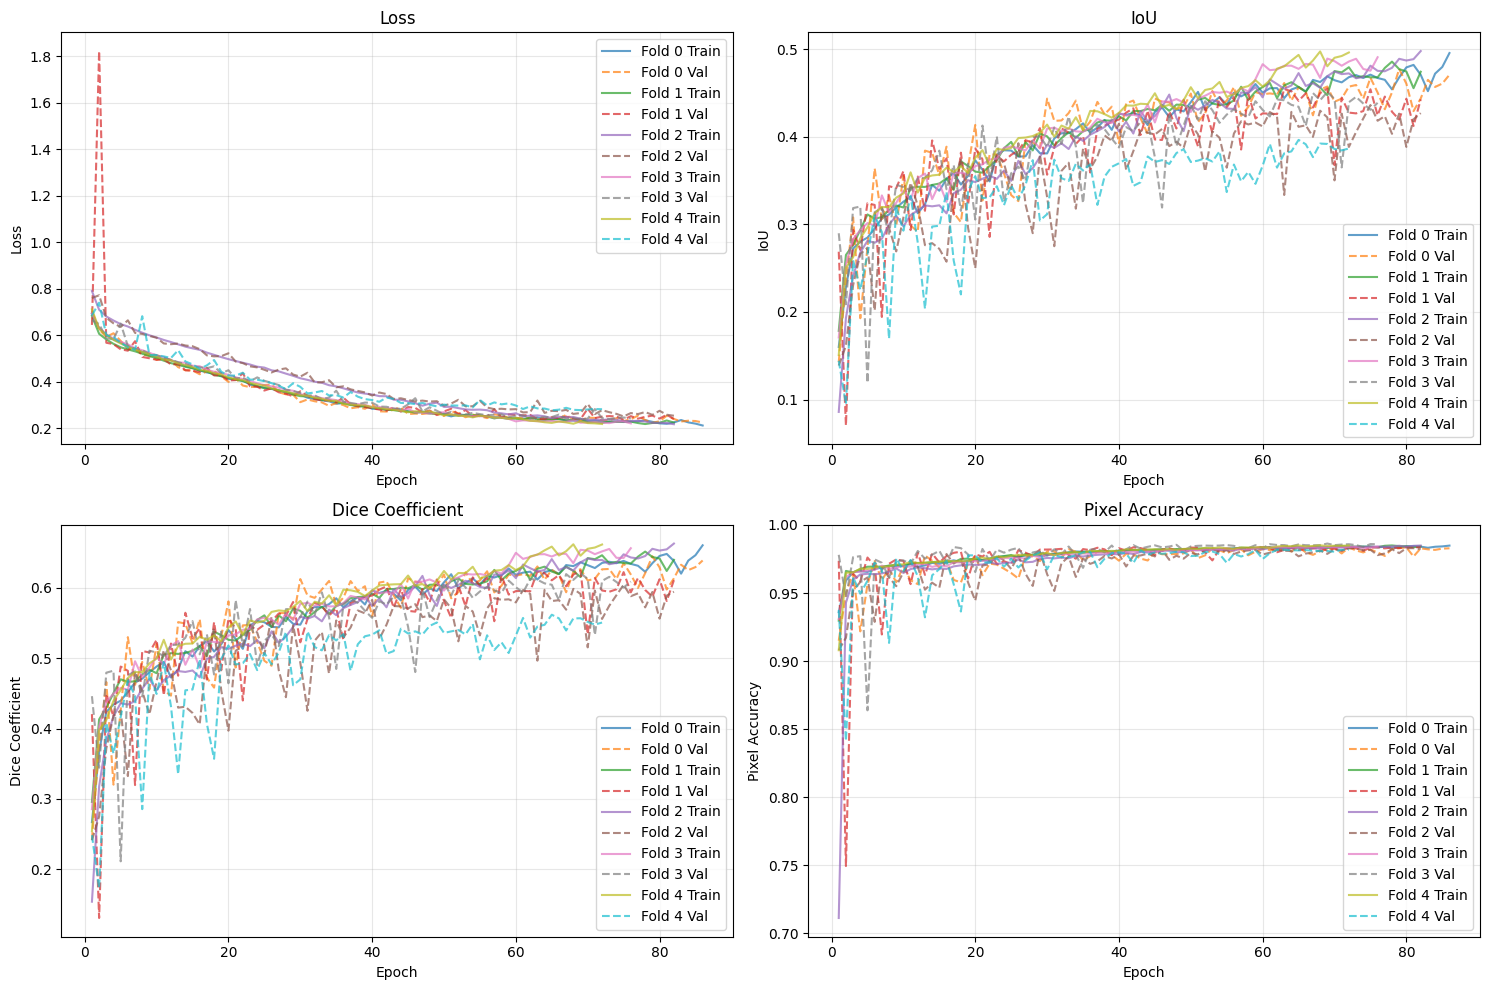

In [ ]:
# Plot training curves
def plot_training_curves(fold_results):
    """Plot training curves"""
    n_folds = len(fold_results)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['loss', 'iou', 'dice', 'accuracy']
    titles = ['Loss', 'IoU', 'Dice Coefficient', 'Pixel Accuracy']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        
        for fold_idx, fold_result in enumerate(fold_results):
            history = fold_result['history']
            epochs = range(1, len(history[f'train_{metric}']) + 1)
            
            ax.plot(epochs, history[f'train_{metric}'], 
                   label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
            ax.plot(epochs, history[f'val_{metric}'], 
                   label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_curves(fold_results)

Cross-Validation Results Summary:
 Fold  Val Loss  Val IoU  Val Dice
    0  0.222710 0.477404  0.644780
    1  0.235962 0.455055  0.624318
    2  0.250471 0.436160  0.604102
    3  0.237556 0.451032  0.620535
    4  0.276730 0.396399  0.561688

Statistics:
           Fold  Val Loss   Val IoU  Val Dice
count  5.000000  5.000000  5.000000  5.000000
mean   2.000000  0.244686  0.443210  0.611085
std    1.581139  0.020434  0.030049  0.031179
min    0.000000  0.222710  0.396399  0.561688
25%    1.000000  0.235962  0.436160  0.604102
50%    2.000000  0.237556  0.451032  0.620535
75%    3.000000  0.250471  0.455055  0.624318
max    4.000000  0.276730  0.477404  0.644780


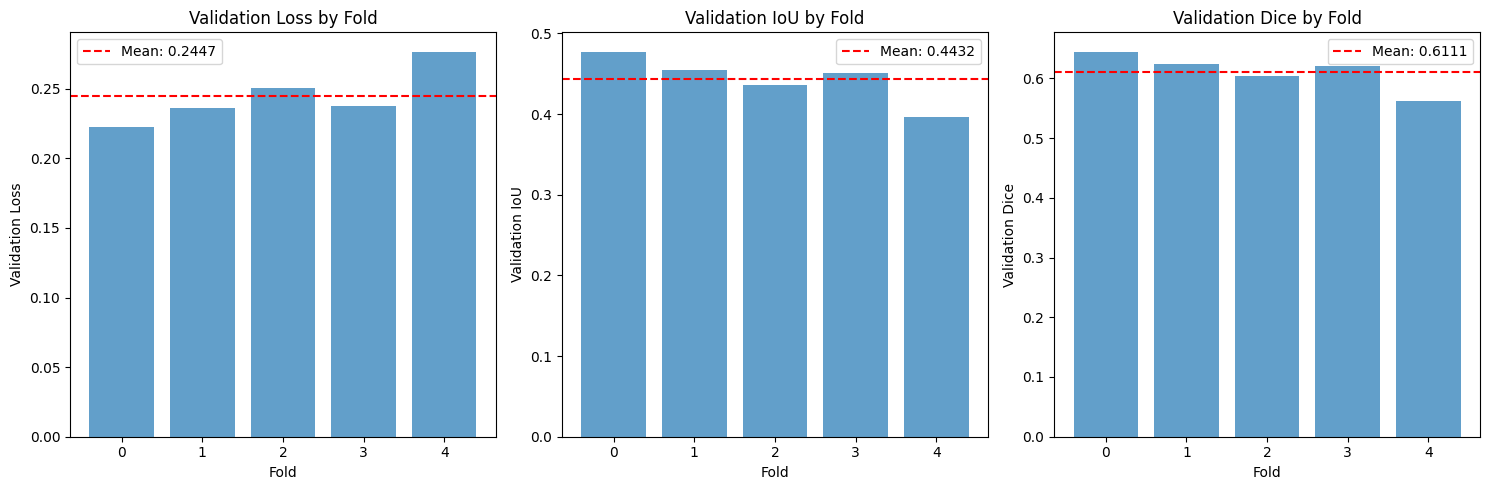

In [ ]:
# Cross-validation results summary
def summarize_cv_results(fold_results):
    """Summarize cross-validation results"""
    metrics = ['best_val_loss', 'best_val_iou', 'best_val_dice']
    metric_names = ['Validation Loss', 'Validation IoU', 'Validation Dice']
    
    results_df = pd.DataFrame()
    
    for fold_result in fold_results:
        fold_data = {
            'Fold': fold_result['fold'],
            'Val Loss': fold_result['best_val_loss'],
            'Val IoU': fold_result['best_val_iou'],
            'Val Dice': fold_result['best_val_dice']
        }
        results_df = pd.concat([results_df, pd.DataFrame([fold_data])], ignore_index=True)
    
    # Calculate statistics
    summary_stats = results_df.describe()
    
    print("Cross-Validation Results Summary:")
    print("="*50)
    print(results_df.to_string(index=False))
    print("\nStatistics:")
    print(summary_stats)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (metric, name) in enumerate(zip(['Val Loss', 'Val IoU', 'Val Dice'], metric_names)):
        ax = axes[i]
        ax.bar(results_df['Fold'], results_df[metric], alpha=0.7)
        ax.set_title(f'{name} by Fold')
        ax.set_xlabel('Fold')
        ax.set_ylabel(name)
        
        # Add mean line
        mean_val = results_df[metric].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                  label=f'Mean: {mean_val:.4f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Summarize results
cv_results = summarize_cv_results(fold_results)

## 10. Model Prediction Visualization

This section implements comprehensive visualization tools for model predictions, enabling detailed qualitative assessment of segmentation performance and providing insights into model behavior on real data.

### Prediction Visualization Framework:

#### Multi-Sample Analysis:
- **Random Sample Selection**: Unbiased evaluation across validation dataset
- **Side-by-Side Comparison**: Input image, ground truth, and prediction display
- **Batch Processing**: Efficient visualization of multiple samples simultaneously
- **Quality Assessment**: Visual evaluation of segmentation accuracy

#### Image Processing Pipeline:
- **Multi-Channel Handling**: Proper display of 4-channel (RGB+NIR) inputs
- **Denormalization**: Conversion from normalized tensors to displayable images
- **RGB Extraction**: Intelligent channel selection for visualization
- **Mask Processing**: Proper handling of binary segmentation masks

### Visualization Features:

#### Input Image Display:
- **RGB Representation**: Standard color image display from multi-channel input
- **Normalization Reversal**: Accurate color reproduction through denormalization
- **Dynamic Range Clipping**: Proper pixel value range for display
- **Channel Management**: Automatic handling of 3 vs 4-channel inputs

#### Ground Truth Visualization:
- **Binary Mask Display**: Clear representation of true dead tree regions
- **Grayscale Rendering**: Intuitive black/white visualization
- **Shape Consistency**: Proper dimensional handling for display
- **Reference Standard**: Baseline for prediction comparison

#### Prediction Analysis:
- **Probability Maps**: Continuous prediction confidence visualization
- **Sigmoid Output**: Direct model output without thresholding
- **Uncertainty Visualization**: Areas of high/low prediction confidence
- **Comparative Assessment**: Direct comparison with ground truth

### Best Model Selection:
- **Performance-Based Selection**: Automatic identification of highest-performing fold
- **IoU Optimization**: Selection based on intersection over union metric
- **Validation Dataset**: Predictions on unseen validation data
- **Representative Sampling**: Diverse examples for comprehensive evaluation

### Quality Insights:
- **Segmentation Precision**: Visual assessment of boundary accuracy
- **False Positive/Negative Analysis**: Identification of common error patterns
- **Confidence Calibration**: Evaluation of prediction uncertainty
- **Clinical Validation**: Practical assessment of segmentation quality

Visualizing predictions from best fold (Fold 0)


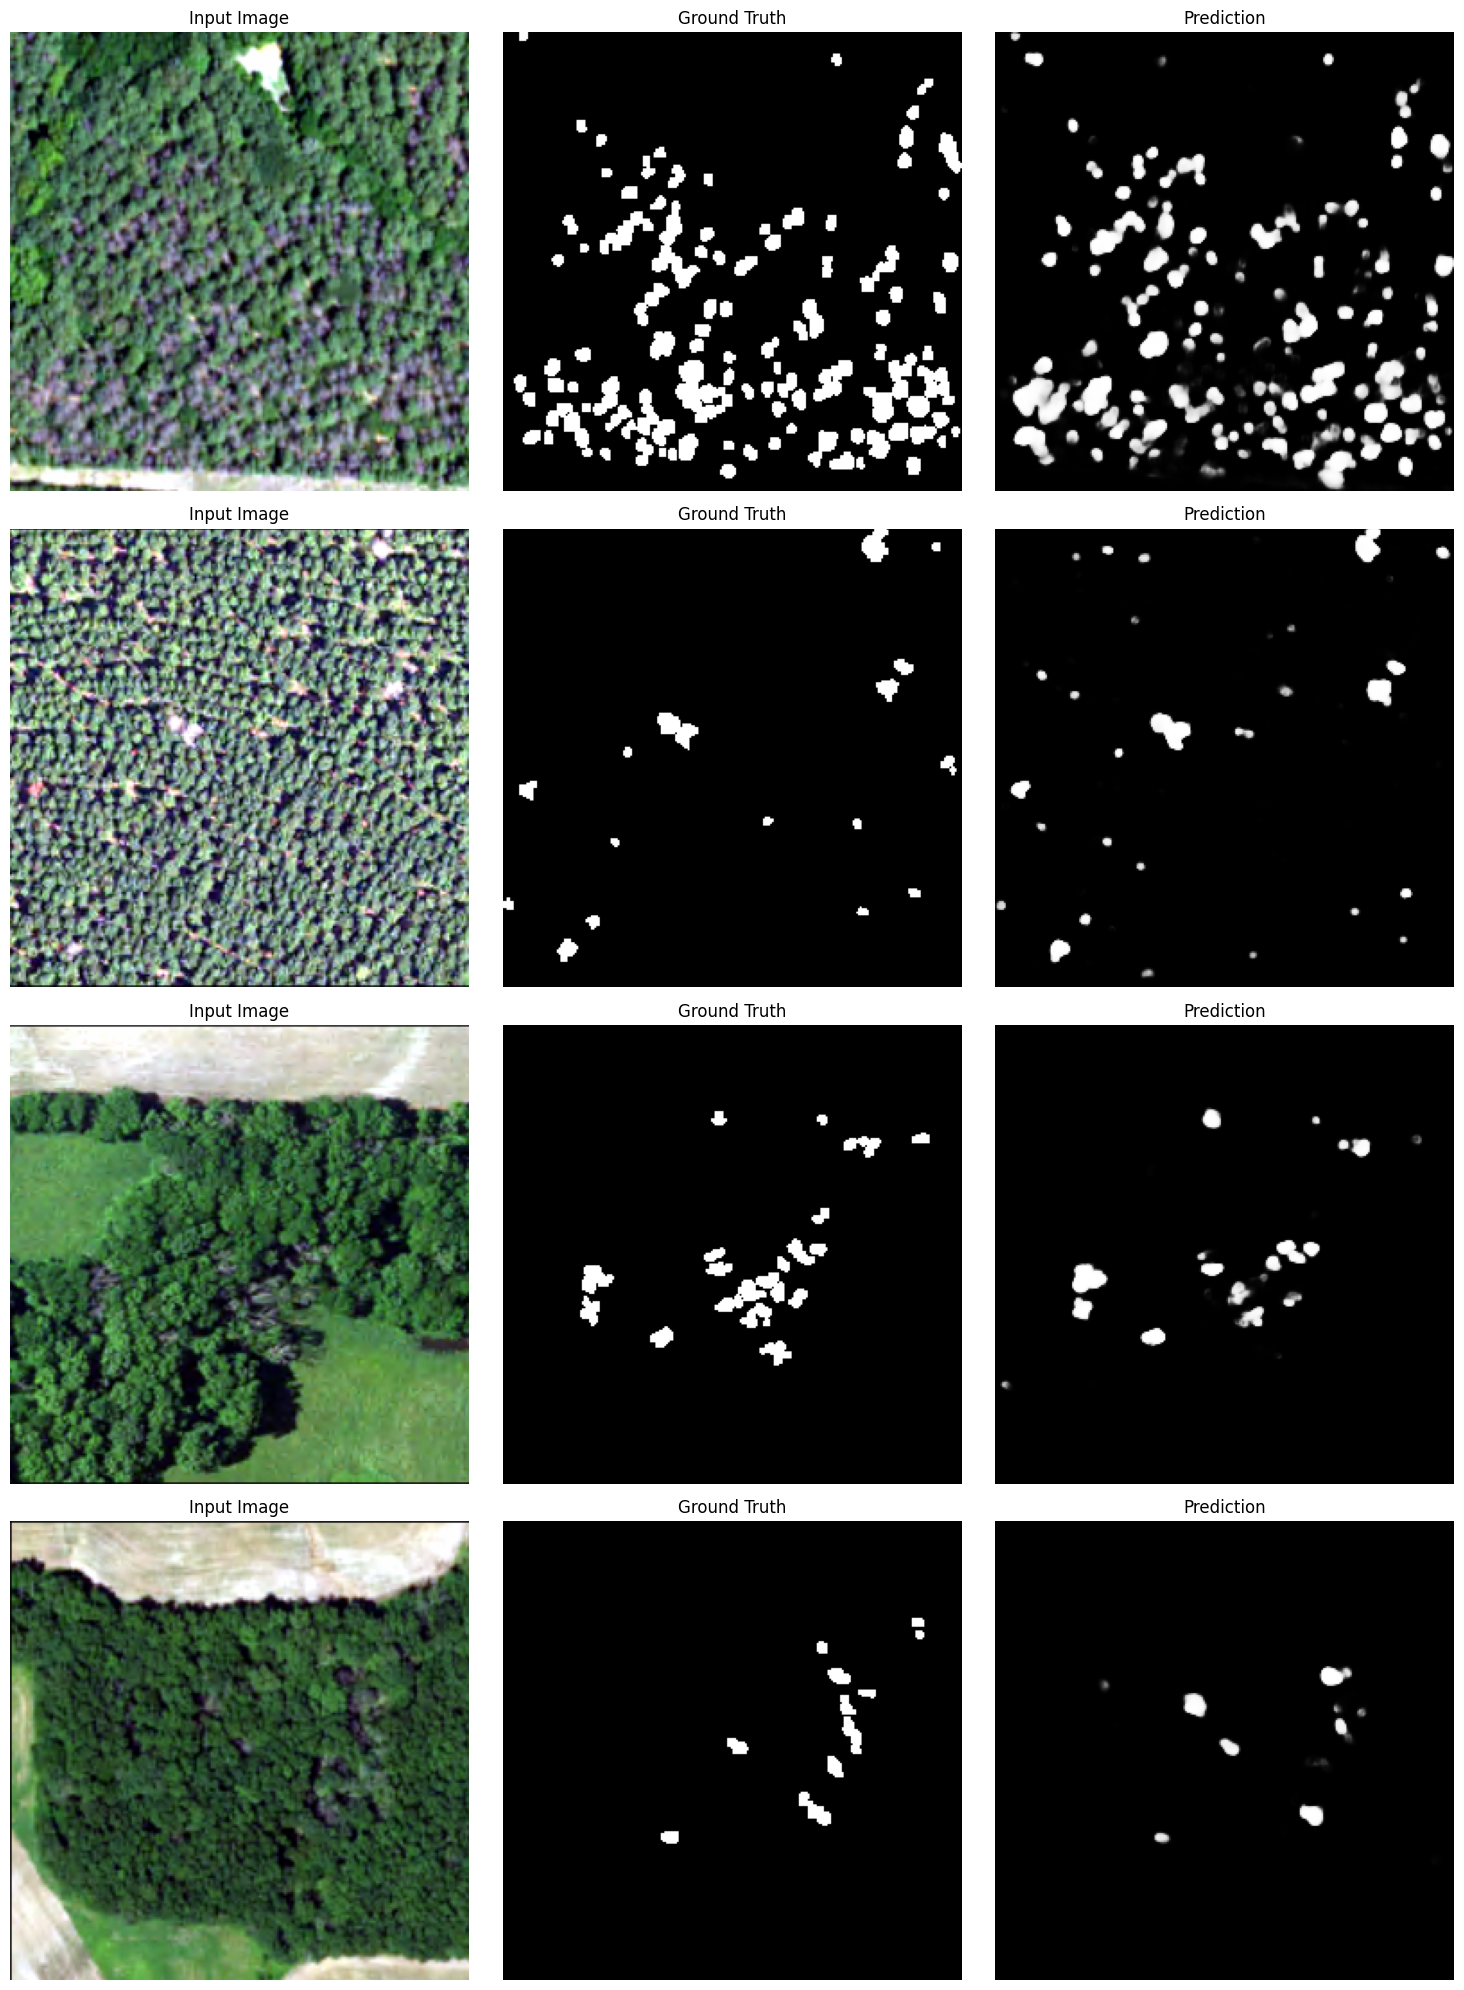

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=4):
    """Visualize model prediction results"""
    model.eval()
    
    # Randomly select samples
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            image, mask = dataset[idx]
            
            # Prediction
            image_input = image.unsqueeze(0).to(device)
            pred = model(image_input)
            pred = pred.cpu().numpy()[0, 0]  # Model already includes sigmoid
            
            # Denormalize image for display (only show first 3 channels RGB)
            image_np = image.numpy().transpose(1, 2, 0)
            if image_np.shape[2] == 4:
                # 4-channel case, only take first 3 channels for display
                image_np = image_np[:, :, :3]
            
            # Denormalize (only for RGB three channels)
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            # Process mask for display
            mask_np = mask.numpy()
            if mask_np.ndim == 3 and mask_np.shape[0] == 1:
                mask_np = mask_np[0]  # Convert from [1, H, W] to [H, W]
            
            # Display images
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions from the best model
if fold_results:
    best_fold = max(fold_results, key=lambda x: x['best_val_iou'])
    print(f"Visualizing predictions from best fold (Fold {best_fold['fold']})")
    
    # Create validation dataset
    input_channels = 4 if config['input_type'] == 'rgb_nir' else 3
    val_dataset = DeadTreeDataset(
        matched_files, 
        folds[best_fold['fold']]['val_idx'],
        input_type=config['input_type'],
        transform=get_transforms('val', input_channels=input_channels)
    )
    
    visualize_predictions(best_fold['model'], val_dataset, device)

## 11. Model Saving and Loading

This section implements comprehensive model persistence and management systems, ensuring trained models can be reliably saved, loaded, and deployed for future use with complete configuration and performance tracking.

In [ ]:
# Save best model
def save_best_model(fold_results, save_dir='/kaggle/working/models'):
    """Save best model"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Find best model
    best_fold = max(fold_results, key=lambda x: x['best_val_iou'])
    
    # Save model
    model_path = os.path.join(save_dir, 'best_unet_model.pth')
    torch.save({
        'model_state_dict': best_fold['model'].state_dict(),
        'fold': best_fold['fold'],
        'best_val_iou': best_fold['best_val_iou'],
        'best_val_dice': best_fold['best_val_dice'],
        'config': config
    }, model_path)
    
    print(f"Best model saved to {model_path}")
    print(f"Best model metrics - IoU: {best_fold['best_val_iou']:.4f}, Dice: {best_fold['best_val_dice']:.4f}")
    
    return model_path

# Save training history
def save_training_history(fold_results, save_dir='/kaggle/working/models'):
    """Save training history"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save history for each fold
    for fold_result in fold_results:
        history_path = os.path.join(save_dir, f'fold_{fold_result["fold"]}_history.csv')
        history_df = pd.DataFrame(fold_result['history'])
        history_df.to_csv(history_path, index=False)
    
    # Save summary results
    summary_path = os.path.join(save_dir, 'cv_summary.csv')
    cv_results.to_csv(summary_path, index=False)
    
    print(f"Training history saved to {save_dir}")

# Save model and history
if fold_results:
    model_path = save_best_model(fold_results)
    save_training_history(fold_results)

Best model saved to /kaggle/working/models/best_unet_model.pth
Best model metrics - IoU: 0.4774, Dice: 0.6448
Training history saved to /kaggle/working/models
